In [1]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

In [3]:
phantom = np.load(os.path.join(xg.data_path,'phantoms/catphan_low_contrast_256.npy'))
# phantom = np.tile(phantom,[2,2,2])

In [6]:
det = 'CWO'
spectrum_file = 'Al_spectrum'

angles = np.linspace(0,2*np.pi,90)

In [7]:
s = xg.Spectrum()

energies = []
fluence = []

with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
    for line in f:
        energies.append(float(line.split()[0]))
        fluence.append(float(line.split()[1]))

# Check if MV

s.x = np.array(energies)*1000  # to keV
s.y = np.array(fluence)

In [8]:
dump_files = os.path.join(
    xg.data_path, "Detectors", det, '*phsp.npy')
energy_deposition_file = os.path.join(
    xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

kernel, kernels = xg.get_kernel(
                        s, dump_files, energy_deposition_file)

energy_deposition_file = os.path.join(
    xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

energies = s.x
fluence = s.y
deposition_efficiency_file = energy_deposition_file

In [24]:
phantom_mapping = ['air','water','bone','brain','bone']

# Don't want to look for zeros
useful_phantom = phantom != 0

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])

deposition_summed = np.array([    0.        ,  2395.25927928,  3434.7986552 ,  4416.62822646,
    5373.00952021,  6067.40938147,  6955.18365258,  7901.50699458,
    8860.76810654, 20457.403665  , 22916.6726841 , 26069.46417263,
   29726.25290966, 31589.13314065, 49335.93687135])

masks = np.zeros([len(phantom_mapping)-1,useful_phantom.shape[0],useful_phantom.shape[1],useful_phantom.shape[2]])
mapping_functions = []

# Get the mapping functions for the different tissues
for ii in range(1,len(phantom_mapping)):

    mapping_functions.append(xg.get_mu(phantom_mapping[ii]))
    masks[ii-1] = phantom == ii

geo = tigre.geometry_default(high_quality=False,nVoxel=phantom.shape)
geo.dDetector = np.array([0.8, 0.8])*4
geo.sDetector = geo.dDetector * geo.nDetector  
# angles = np.linspace(0, 0, 1, dtype=np.float32)

energy = 100

phantom2 = phantom.copy().astype(np.float32)

In [25]:
%%time

proj = []

for energy in original_energies_keV[1:]:
    for ii in range(0,len(phantom_mapping)-1):

        phantom2[masks[ii].astype(bool)] = mapping_functions[ii](energy)

    proj.append(np.squeeze(tigre.Ax(phantom2,geo,angles)))

proj_filt = proj.copy()

CPU times: user 2.84 s, sys: 1.36 s, total: 4.2 s
Wall time: 4.23 s


<IPython.core.display.Javascript object>


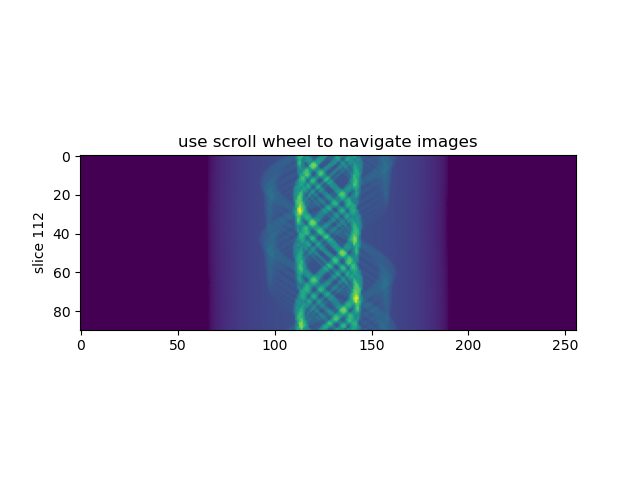

In [26]:

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

X = np.transpose(np.array(proj[0][:][:]),[0,2,1])

tracker = IndexTracker(ax, X)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [27]:
out = []

for kk in range(len(angles)):
    for ii in range(len(original_energies_keV)-1):

        proj_filt[ii] = fftconvolve(proj[ii][kk],kernels[ii+1], mode = 'same')

    fluence_small = np.interp(original_energies_keV[1:],np.array(energies)*1000, fluence)

    weights_small = fluence_small*deposition_summed

    out.append(np.array(proj_filt).T@weights_small)

In [28]:
np.array(proj_filt).shape

(15, 256, 256)

<IPython.core.display.Javascript object>


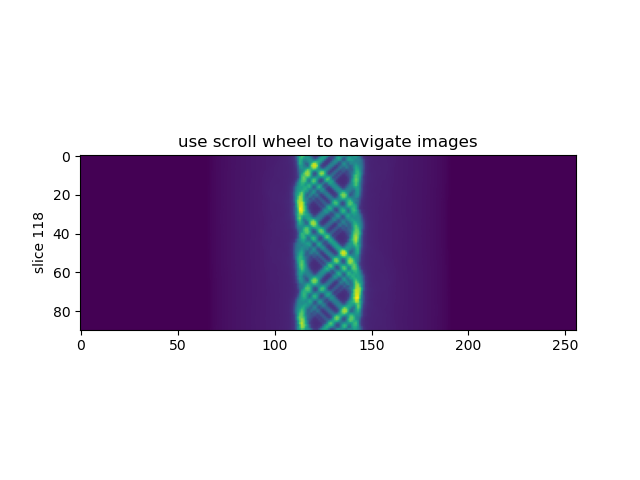

In [29]:

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

X = np.array(out)

tracker = IndexTracker(ax, X)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [30]:
img = tigre.algorithms.FDK(
    np.transpose(np.array(out),[0,2,1]), geo, angles)

In [31]:
np.array(out).shape

(90, 256, 256)

<IPython.core.display.Javascript object>


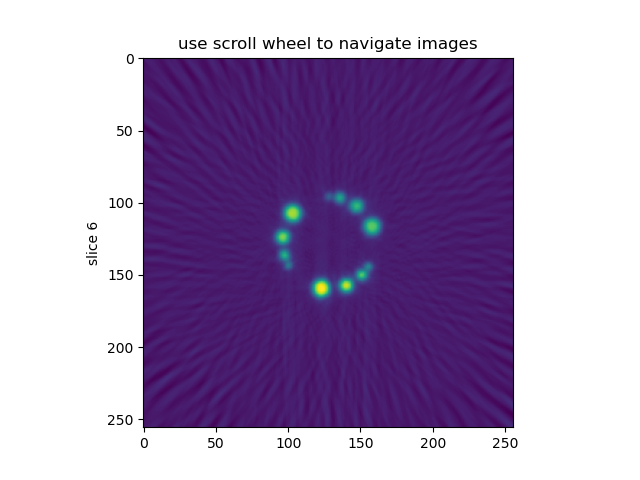

In [33]:

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()


fig, ax = plt.subplots(1, 1)

X = np.array(img)

tracker = IndexTracker(ax, X.T)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

# Segmenting the catphan dataset

In [3]:
import pylinac.core.image as im

In [22]:
from pylinac import CatPhan600

cbct = CatPhan600.from_demo_images()

In [23]:
cbct

<IPython.core.display.Javascript object>


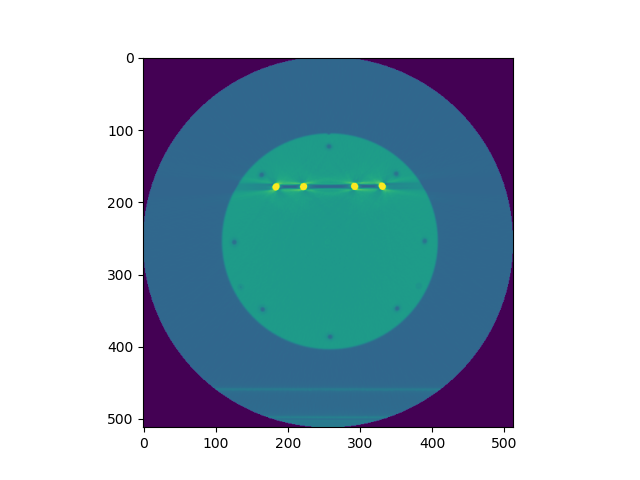

In [24]:
plt.figure()
plt.imshow(cbct.dicom_stack.images[0].array)

In [25]:
scan = [image.array for image in cbct.dicom_stack.images]

<IPython.core.display.Javascript object>


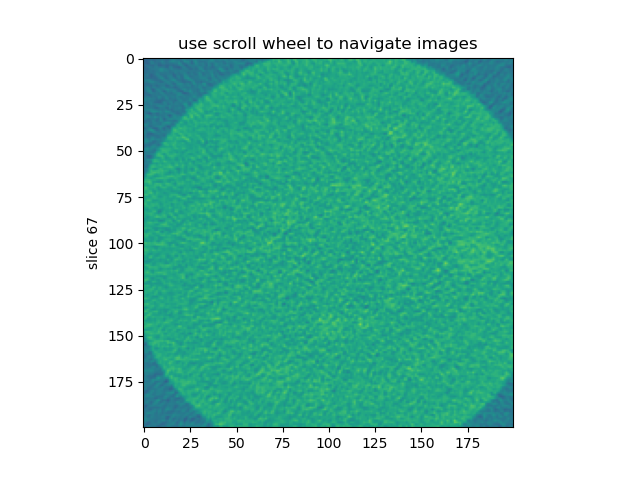

In [28]:
fig, ax = plt.subplots(1, 1)

X = np.array(scan).T[150:350,150:350,:]

tracker = IndexTracker(ax, X)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [14]:
from sklearn import mixture

<IPython.core.display.Javascript object>


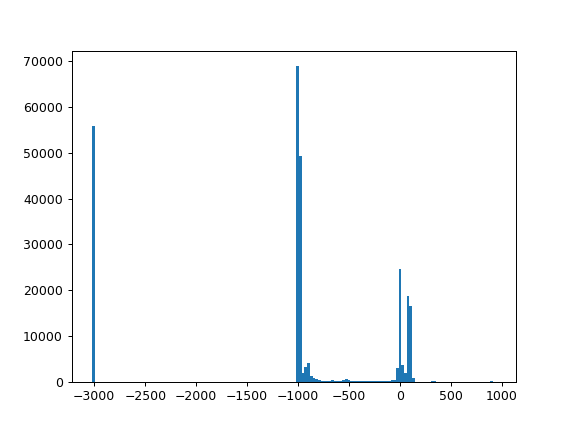

In [15]:
KM = mixture.BayesianGaussianMixture(n_components=11)

plt.figure()
plt.hist(X[:,:,164].flatten().reshape(1, -1).T,bins = 150);

In [16]:
res = KM.fit_predict(X[:,:,164].flatten().reshape(1, -1).T)

/home/xcite/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


<IPython.core.display.Javascript object>


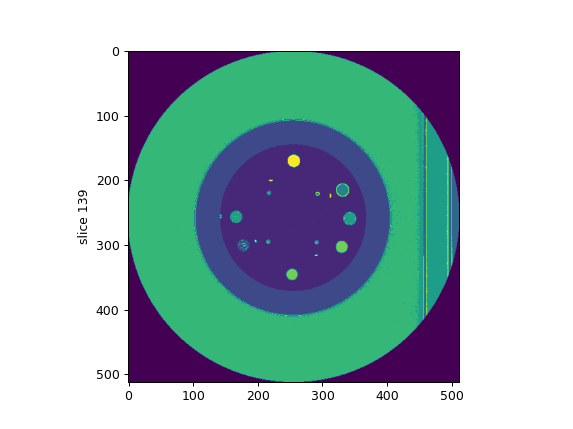

In [17]:
X_b = res.reshape(X[:,:,164].shape)

fig, ax = plt.subplots(1, 1)

plt.imshow(X_b)

<IPython.core.display.Javascript object>


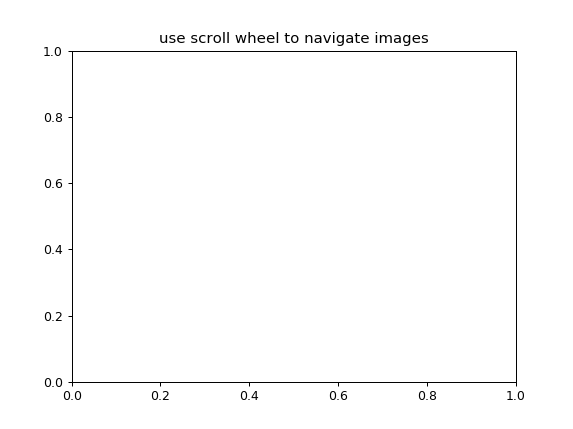

ValueError: not enough values to unpack (expected 3, got 2)

In [228]:
X_b = res.reshape(X[:,:,164].shape)

fig, ax = plt.subplots(1, 1)

tracker = IndexTracker(ax, X_b)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

<IPython.core.display.Javascript object>


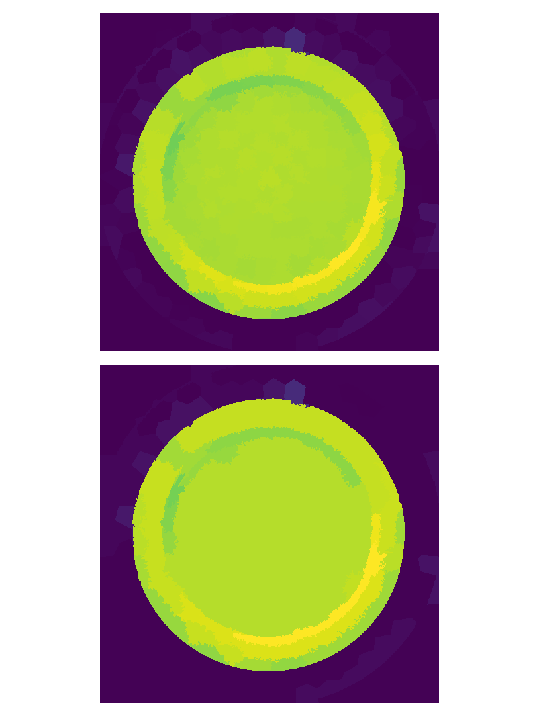

In [200]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


img = X[:,:,0]

labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 29)
out2 = color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True,
                       figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

In [194]:
X[:,:,0].shape

(512, 512)

In [199]:
!pip freeze | grep image

image==1.5.32
imageio==2.6.1
imagesize==1.2.0
scikit-image==0.16.2


In [202]:
import iterative_gmm

In [233]:
import tomopy

[autoreload of matplotlib failed: Traceback (most recent call last):
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: compare_versions() requires a code object with 0 free vars, not 2
]
[autoreload of matplotlib.rcsetup failed: Traceback (most recent call last):
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  

[autoreload of matplotlib.patches failed: Traceback (most recent call last):
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
V

[autoreload of matplotlib.dates failed: Traceback (most recent call last):
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
Val

[autoreload of mpl_toolkits.axes_grid1.axes_grid failed: Traceback (most recent call last):
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getatt

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
def create_circular_mask(x, y, r, index, image):
    
    h,w = image.shape
    
    center = [x*int(w/2)/8 + int(w/2),y*int(h/2)/8 + int(h/2)]

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if r is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= r*int(w/2)/8
    
    
    image[mask] = index
#     return mask



In [5]:
im = np.zeros([512,512])
#im = np.zeros([256,256])
ii = 1

# CTMAT(x) formel=H2O dichte=x
LEN = 100

A0  = 87.7082*np.pi/180
A1 = 108.3346*np.pi/180
A2 = 126.6693*np.pi/180
A3 = 142.7121*np.pi/180
A4 = 156.4631*np.pi/180
A5 = 167.9223*np.pi/180
A6 = 177.0896*np.pi/180
A7 = 183.9651*np.pi/180
A8 = 188.5487*np.pi/180

B0 = 110.6265*np.pi/180
B1 = 142.7121*np.pi/180
B2 = 165.6304*np.pi/180
B3 = 179.3814*np.pi/180

# Phantom 
# ++++ module body ++++++++++++++++++++++++++++++++++++++++++++++++++ */                        
create_circular_mask(x= 0.000,  y= 0.000,  r=8.0, index = ii, image = im)

ii += 1

# ++++ supra-slice 1.0% targets +++++++++++++++++++++++++++++++++++++++ */
create_circular_mask(x= 5*cos(A0),  y= 5*sin(A0),  r=0.75, index = ii, image = im)
create_circular_mask(x= 5*cos(A1),  y= 5*sin(A1),  r=0.45, index = ii, image = im)
create_circular_mask(x= 5*cos(A2),  y= 5*sin(A2),  r=0.40, index = ii, image = im)
create_circular_mask(x= 5*cos(A3),  y= 5*sin(A3),  r=0.35, index = ii, image = im)
create_circular_mask(x= 5*cos(A4),  y= 5*sin(A4),  r=0.30, index = ii, image = im)
create_circular_mask(x= 5*cos(A5),  y= 5*sin(A5),  r=0.25, index = ii, image = im)
create_circular_mask(x= 5*cos(A6),  y= 5*sin(A6),  r=0.20, index = ii, image = im)
create_circular_mask(x= 5*cos(A7),  y= 5*sin(A7),  r=0.15, index = ii, image = im)
create_circular_mask(x= 5*cos(A8),  y= 5*sin(A8),  r=0.10, index = ii, image = im)

ii += 1

# ++++ supra-slice 0.3% targets +++++++++++++++++++++++++++++++++++++++ */
create_circular_mask(x= 5*cos(A0+2/3*np.pi),  y= 5*sin(A0+2/3*np.pi),  r=0.75, index = ii, image = im)
create_circular_mask(x= 5*cos(A1+2/3*np.pi),  y= 5*sin(A1+2/3*np.pi),  r=0.45, index = ii, image = im)
create_circular_mask(x= 5*cos(A2+2/3*np.pi),  y= 5*sin(A2+2/3*np.pi),  r=0.40, index = ii, image = im)
create_circular_mask(x= 5*cos(A3+2/3*np.pi),  y= 5*sin(A3+2/3*np.pi),  r=0.35, index = ii, image = im)
create_circular_mask(x= 5*cos(A4+2/3*np.pi),  y= 5*sin(A4+2/3*np.pi),  r=0.30, index = ii, image = im)
create_circular_mask(x= 5*cos(A5+2/3*np.pi),  y= 5*sin(A5+2/3*np.pi),  r=0.25, index = ii, image = im)
create_circular_mask(x= 5*cos(A6+2/3*np.pi),  y= 5*sin(A6+2/3*np.pi),  r=0.20, index = ii, image = im)
create_circular_mask(x= 5*cos(A7+2/3*np.pi),  y= 5*sin(A7+2/3*np.pi),  r=0.15, index = ii, image = im)
create_circular_mask(x= 5*cos(A8+2/3*np.pi),  y= 5*sin(A8+2/3*np.pi),  r=0.10, index = ii, image = im)

ii += 1

# ++++ supra-slice 0.5% targets +++++++++++++++++++++++++++++++++++++++ */
create_circular_mask(x= 5*cos(A0+4/3*np.pi),  y= 5*sin(A0+4/3*np.pi),  r=0.75, index = ii, image = im)
create_circular_mask(x= 5*cos(A1+4/3*np.pi),  y= 5*sin(A1+4/3*np.pi),  r=0.45, index = ii, image = im)
create_circular_mask(x= 5*cos(A2+4/3*np.pi),  y= 5*sin(A2+4/3*np.pi),  r=0.40, index = ii, image = im)
create_circular_mask(x= 5*cos(A3+4/3*np.pi),  y= 5*sin(A3+4/3*np.pi),  r=0.35, index = ii, image = im)
create_circular_mask(x= 5*cos(A4+4/3*np.pi),  y= 5*sin(A4+4/3*np.pi),  r=0.30, index = ii, image = im)
create_circular_mask(x= 5*cos(A5+4/3*np.pi),  y= 5*sin(A5+4/3*np.pi),  r=0.25, index = ii, image = im)
create_circular_mask(x= 5*cos(A6+4/3*np.pi),  y= 5*sin(A6+4/3*np.pi),  r=0.20, index = ii, image = im)
create_circular_mask(x= 5*cos(A7+4/3*np.pi),  y= 5*sin(A7+4/3*np.pi),  r=0.15, index = ii, image = im)
create_circular_mask(x= 5*cos(A8+4/3*np.pi),  y= 5*sin(A8+4/3*np.pi),  r=0.10, index = ii, image = im)

ii += 1

# ++++ subslice 1.0% targets 7mm long +++++++++++++++++++++++++++++++++ */
create_circular_mask(x= 2.5*cos(B0),  y= 2.5*sin(B0),  r=0.45, index = ii, image = im)
create_circular_mask(x= 2.5*cos(B1),  y= 2.5*sin(B1),  r=0.35, index = ii, image = im)
create_circular_mask(x= 2.5*cos(B2),  y= 2.5*sin(B2),  r=0.25, index = ii, image = im)
create_circular_mask(x= 2.5*cos(B3),  y= 2.5*sin(B3),  r=0.15, index = ii, image = im)

ii += 1

# ++++ subslice 1.0% targets 3mm long +++++++++++++++++++++++++++++++++ */
create_circular_mask(x= 2.5*cos(B0+2/3*np.pi) ,y= 2.5*sin(B0+2/3*np.pi),  r=0.45  , index = ii, image = im)
create_circular_mask(x= 2.5*cos(B1+2/3*np.pi) ,y= 2.5*sin(B1+2/3*np.pi),  r=0.35  , index = ii, image = im)
create_circular_mask(x= 2.5*cos(B2+2/3*np.pi) ,y= 2.5*sin(B2+2/3*np.pi),  r=0.25  , index = ii, image = im)
create_circular_mask(x= 2.5*cos(B3+2/3*np.pi) ,y= 2.5*sin(B3+2/3*np.pi),  r=0.15  , index = ii, image = im)

ii += 1

# ++++ subslice 1.0% targets 5mm long +++++++++++++++++++++++++++++++++ */
create_circular_mask(x= 2.5*cos(B0+4/3*np.pi) ,y= 2.5*sin(B0+4/3*np.pi),  r=0.45  , index = ii, image = im)
create_circular_mask(x= 2.5*cos(B1+4/3*np.pi) ,y= 2.5*sin(B1+4/3*np.pi),  r=0.35  , index = ii, image = im)
create_circular_mask(x= 2.5*cos(B2+4/3*np.pi) ,y= 2.5*sin(B2+4/3*np.pi),  r=0.25  , index = ii, image = im)
create_circular_mask(x= 2.5*cos(B3+4/3*np.pi) ,y= 2.5*sin(B3+4/3*np.pi),  r=0.15  , index = ii, image = im)
 

<IPython.core.display.Javascript object>


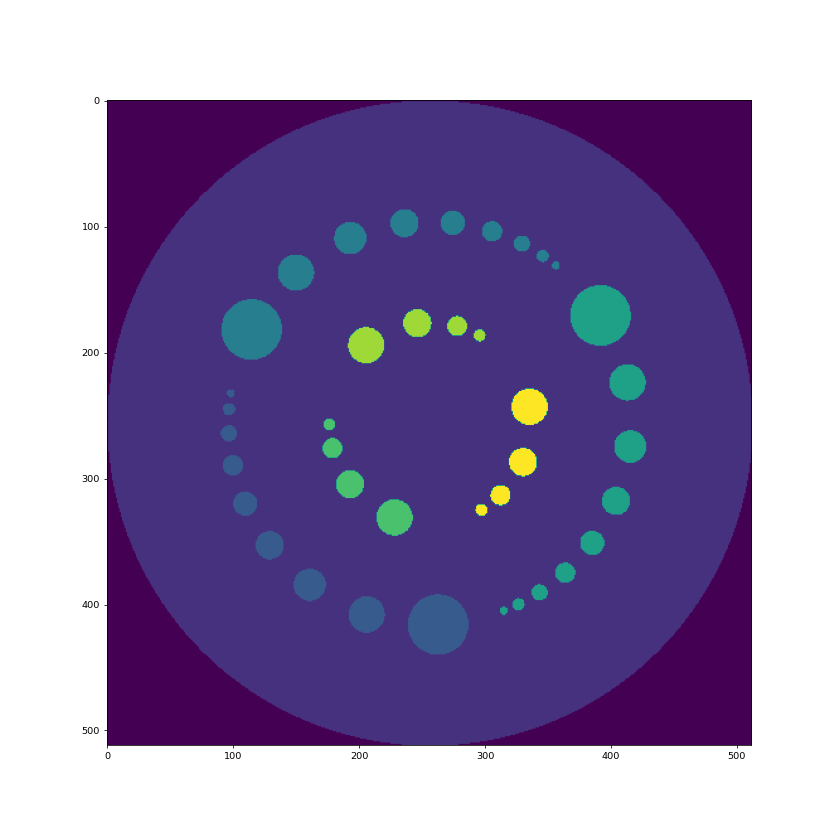

In [6]:
plt.figure(figsize=[12,12])
plt.imshow(im)

In [7]:
im_stack = np.tile(im,[10,1,1])

<IPython.core.display.Javascript object>


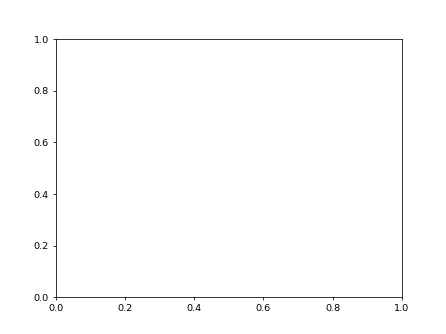

NameError: name 'IndexTracker' is not defined

In [8]:
# X_b = res.reshape(X[:,:,164].shape)

fig, ax = plt.subplots(1, 1)

tracker = IndexTracker(ax, im_stack.T)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [9]:
np.save('catphan_low_contrast_512_8cm',im_stack)

In [10]:
!mv catphan_low_contrast_512_8cm.npy ../xpecgen/data/phantoms/

In [8]:
%pylab nbagg
import os
import xpecgen as xg

Populating the interactive namespace from numpy and matplotlib


In [6]:
phantom = np.load(os.path.join(xg.data_path,f'phantoms/segemented_head_phantom.npy'))

<IPython.core.display.Javascript object>


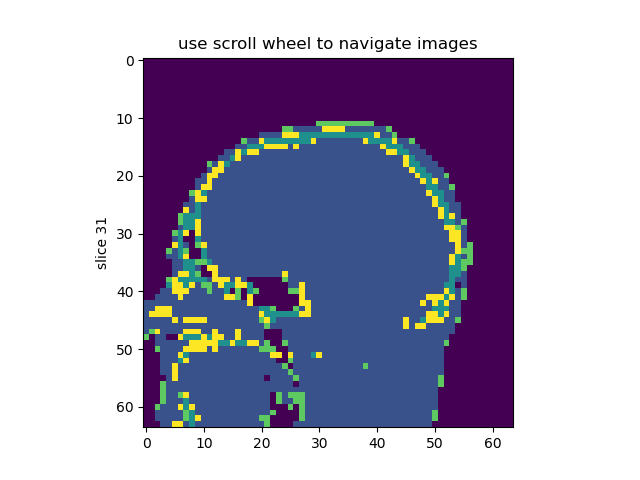

In [9]:
fig, ax = plt.subplots(1, 1)

tracker = IndexTracker(ax, phantom)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [10]:
from pylinac.ct import CTP515

from pylinac import CatPhan600

cbct = CatPhan600.from_demo_images()

<IPython.core.display.Javascript object>


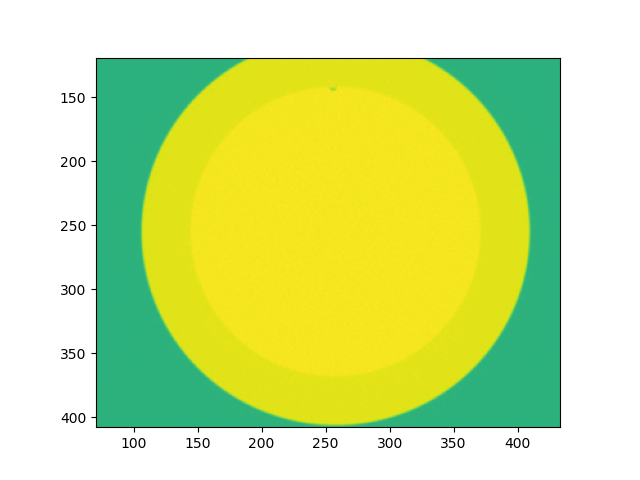

In [21]:
plt.imshow(cbct.dicom_stack[110].array)

In [34]:
recon = np.load('../xpecgen/data/projs/low_contrast_recon.npy')

<IPython.core.display.Javascript object>


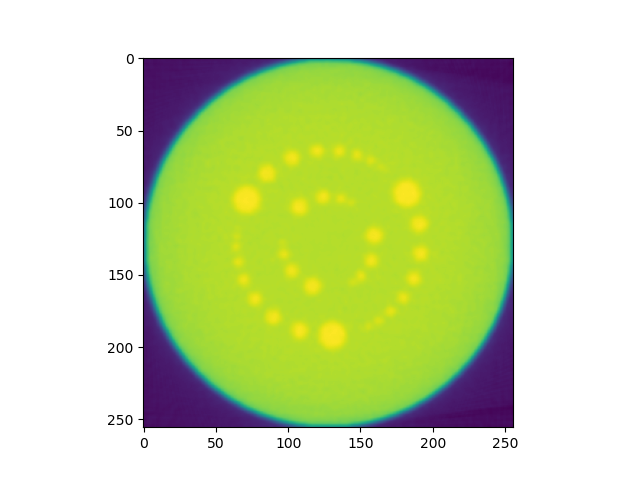

In [35]:
plt.figure()
plt.imshow(recon[1])

In [62]:
recon_slice = recon[0]

In [55]:
np.array([im == 2]).squeeze().dtype

dtype('bool')

<IPython.core.display.Javascript object>


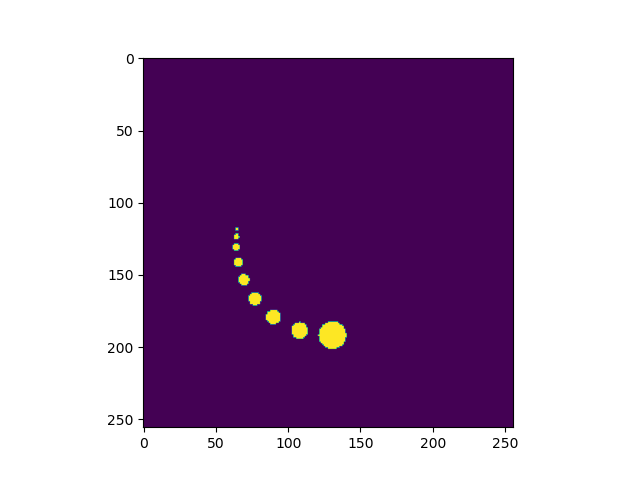

In [56]:
plt.figure()
plt.imshow(np.array([im == 2]).squeeze())

In [59]:
# im = np.zeros([512,512])
im = np.zeros([256,256])
ii = 1

# CTMAT(x) formel=H2O dichte=x
LEN = 100

A0  = 87.7082*np.pi/180
A1 = 108.3346*np.pi/180
A2 = 126.6693*np.pi/180
A3 = 142.7121*np.pi/180
A4 = 156.4631*np.pi/180
A5 = 167.9223*np.pi/180
A6 = 177.0896*np.pi/180
A7 = 183.9651*np.pi/180
A8 = 188.5487*np.pi/180

B0 = 110.6265*np.pi/180
B1 = 142.7121*np.pi/180
B2 = 165.6304*np.pi/180
B3 = 179.3814*np.pi/180

# Phantom 
# ++++ module body ++++++++++++++++++++++++++++++++++++++++++++++++++ */                        
create_circular_mask(x= 0.000,  y= 0.000,  r=1.0, index = ii, image = im)

ii += 1

# ++++ supra-slice 1.0% targets +++++++++++++++++++++++++++++++++++++++ */
create_circular_mask(x= 5*cos(A0),  y= 5*sin(A0),  r=0.75, index = ii, image = im); ii += 1
create_circular_mask(x= 5*cos(A1),  y= 5*sin(A1),  r=0.45, index = ii, image = im); ii += 1
create_circular_mask(x= 5*cos(A2),  y= 5*sin(A2),  r=0.40, index = ii, image = im); ii += 1
create_circular_mask(x= 5*cos(A3),  y= 5*sin(A3),  r=0.35, index = ii, image = im); ii += 1
create_circular_mask(x= 5*cos(A4),  y= 5*sin(A4),  r=0.30, index = ii, image = im); ii += 1
create_circular_mask(x= 5*cos(A5),  y= 5*sin(A5),  r=0.25, index = ii, image = im); ii += 1
create_circular_mask(x= 5*cos(A6),  y= 5*sin(A6),  r=0.20, index = ii, image = im); ii += 1
create_circular_mask(x= 5*cos(A7),  y= 5*sin(A7),  r=0.15, index = ii, image = im); ii += 1
create_circular_mask(x= 5*cos(A8),  y= 5*sin(A8),  r=0.10, index = ii, image = im); ii += 1

<IPython.core.display.Javascript object>


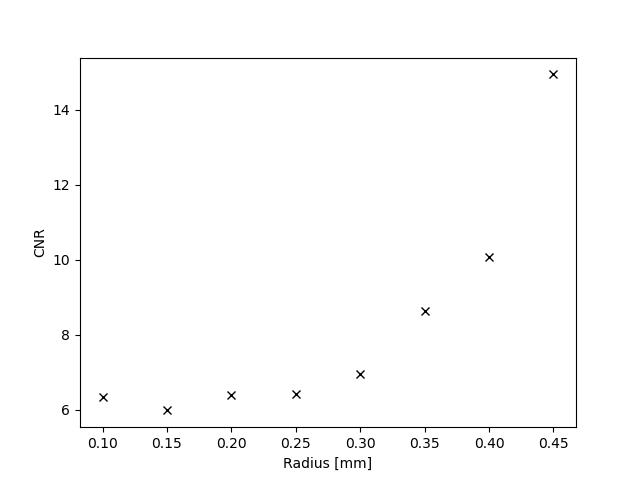

Text(0.5, 0, 'Radius [mm]')

In [68]:
contrast = []
noise = []
cnr = []

ii = 1

ref_mean = np.mean(recon_slice[im == ii])
ref_std = np.std(recon_slice[im == ii])

for ii in range(2,11):
    
    contrast.append(np.abs(np.mean(recon_slice[im == ii])- ref_mean))
    noise.append(np.std(recon_slice[im == ii]))
    
    cnr.append(contrast[-1]/(sqrt(noise[-1]**2 + ref_std**2)))
    
rs = np.linspace(0.1,0.45,8)

plt.figure()
plt.plot(rs,cnr[:-1],'kx')
plt.ylabel('CNR')
plt.xlabel('Radius [mm]')